__CAIO FELIPE DE B. ANDRADE__

   - __Notebook:__ PS DHAUZ
   - __Conteúdo:__ Modelo de classificação para cancelamento de reservas de hotéis

Carregando os pacotes necessários e tirando a notação científica

In [108]:
library(data.table)
library(dplyr)
library(expss)
library(descr)
library(arules)
library(Information)
library(InformationValue)
library(car)
library(caret)
library(scorecard)

options(scipen=999)

Warning message:
"package 'scorecard' was built under R version 4.0.5"

Attaching package: 'scorecard'


The following object is masked from 'package:car':

    vif




__Fazendo a leitura da base de dados__

In [53]:
dados <- fread('C:\\Users\\Caio Felipe\\Documents\\Trabalhos e Consultorias\\DHAUZ\\cancellation_prediction.csv')
#head(dados)

__1. Análise Exploratória Univariada__

- Essa fase é importante para entender bem a base de dados e características das variáveis antes de seguir para qualquer tipo de análise mais robusta.
- A análise de cada variável teve como objetivo verificar as distribuições, missings e identificar possibilidades de agrupamentos que serão utilizados na modelagem. Os agrupamentos serão confirmados na análise bivariada com a variável resposta!

____________________________________________________________________________________________________________________________
- Deixei os códigos abaixo como comentário para que não apareçam todas as tabelas nos resultados. Mantive a exibição de duas tabelas apenas como exemplo.

In [54]:
##### Análise das Variáveis Qualitativas

#cro(dados$type)
#cro(dados$year_arrival_date)
#cro(dados$month_arrival_date)
#cro(dados$week_number_arrival_date)
#cro(dados$breakfast)
#cro(dados$country)  
#cro(dados$market_segment) 
#cro(dados$distribution_channel) 
#cro(dados$repeated_guest)
#cro(dados$reserved_room) 
#cro(dados$deposit_policy)
#cro(dados$id_travel_agency_booking)
#cro(dados$id_person_booking)
#cro(dados$customer_type)
print('Visão da variável sobre vagas de estacionamento')
cro(dados$required_car_parking_spaces) 

##### Análise das Variáveis Quantitativas

print('Visão da variável sobre requisições especiais')
cro(dados$total_of_special_requests)

#Quantidade de dias da viagem
#summary(dados$num_weekend_nights)
#boxplot(dados$num_weekend_nights)
#summary(dados$num_workweek_nights)
#boxplot(dados$num_workweek_nights)
##Verificando consistÊncia das maiores reservas
#View(dados[dados$num_workweek_nights>25,])
##O número de dias em fins de semana está ok em relação aos dias de semana

##Antecedência da reserva
#boxplot(dados$days_between_booking_arrival)

##Analisando o número de hóspedes
#summary(dados$num_adults)
#table(dados$num_adults)
#View(dados[dados$num_adults>4,])
#summary(dados$num_babies)
#summary(dados$num_children)

##Cancelamentos e Estadias prévias
#summary(dados$num_previous_cancellations)
#cro(dados$num_previous_cancellations)

#summary(dados$num_previous_stays)
##table(dados$num_previous_stays)

##Alterações
#summary(dados$changes_between_booking_arrival)
#table(dados$changes_between_booking_arrival)

##Preço
#summary(dados$avg_price)
#boxplot(dados$avg_price) 


[1] "Visão da variável sobre vagas de estacionamento"


,,#Total
dados$required_car_parking_spaces,0,111974
,1,7383
,2,28
,3,3
,8,2
,#Total cases,119390


[1] "Visão da variável sobre requisições especiais"


,,#Total
dados$total_of_special_requests,0,70318
,1,33226
,2,12969
,3,2497
,4,340
,5,40
,#Total cases,119390


__Insights iniciais:__
   - Países: 428 valores faltantes(Verificar a forma de utilização);
   - Segmentos: 6 e 7 com valores muito baixos (averiguar na bivariada a possibilidade de agrupamento);
   - Canais: 3 e 4 com valores muito baixos (averiguar na bivariada a possibilidade de agrupamento);
   - Quarto reservado: L e P com valores baixos (averiguar na bivariada a possibilidade de junção com outros ou se é melhor ignorar);
   - Estacionamento: Utilizar em formato de variável dummy para os testes devido à volumetria;
   - Requisições especiais: Categorizar. Verificar melhor quantidade de categorias (aparentemente duas ou três);
   - Antecedência da reserva: Trabalhar em classes para evitar problemas com outliers;
   - Cancelamentos, Estadias prévias e Alterações: Agrupar em dummys ou três categorias (verificar bivariada);
   - Preço: Testar diferentes quantidade de categorias na análise bivariada dado que a variabiliade de preços é grande.

__Preparando a base de dados para o próximo passo (Análises Bivariadas)__
   - Foram retiradas da base 170 observações de reservas que estão sem adultos ou crianças;
   - 223 observações não têm adultos mas têm crianças. Como a representatividade é baixa, escolhi manter por talvez se tratar de autorizações especiais. De qualquer forma, seria um caso para melhor averiguação;
   - Todas as reservas com 5 ou mais adultos (16) foram canceladas. Como a volumetria era baixa, fiz uma observação sobre tais dados e cheguei à conclusão de retirar da base 13 observações com 10 ou mais adultos. Possivelmente, tais reservas foram canceladas devido a algum erro;
   - As 3 reservas com 5 ou 6 adultos, foram mantidas na base. As duas reservas com 5 adultos, que foram canceladas, parecem ser do mesmo cliente pelas características e valores das demais variáveis.

______________________________________________________________________________________________

__2. Análises bivariadas e ajustes nas variáveis para modelagem__

In [55]:
dados <- filter(dados,num_children > 0 | (num_adults > 0 & num_adults < 10))
dd <- dados

__Country:__ Os agrupamentos foram realizados a partir da volumetria de reservas dos países para evitar que tenhamos países com poucas observações.


In [56]:
dd[dd$country=='',]$country <- 'SEM INFO'
#Juntando países com quantidade baixa
t1 <- table(dd$country) %>% as.data.frame
t1 <- t1[t1$Freq<500 & t1$Var1!='SEM INFO',]
paises <- t1$Var1 %>% as.character()
dd[dd$country %in% paises,]$country <- 'OUTROS'
rm(t1,paises)
#cro_rpct(dd$country,dd$cancellation)

paises <- c('BRA','CHN','ITA','PRT','RUS','SEM INFO')
dd$pais <- dd$country
dd[!dd$pais %in% paises,]$pais <- 'OUTROS'
CrossTable(dd$pais,dd$cancellation,prop.t=FALSE,prop.c=FALSE,prop.chisq=FALSE)

   Conteúdo das células 
|-------------------------|
|                       N | 
|      N / Total da linha | 
|-------------------------|

            dd$cancellation
dd$pais          0        1    Total
------------------------------------
BRA           1392      830     2222
             0.626    0.374    0.019
------------------------------------
CHN            537      462      999
             0.538    0.462    0.008
------------------------------------
ITA           2428     1333     3761
             0.646    0.354    0.032
------------------------------------
OUTROS       48865    13772    62637
             0.780    0.220    0.525
------------------------------------
PRT          20977    27493    48470
             0.433    0.567    0.407
------------------------------------
RUS            391      239      630
             0.621    0.379    0.005
------------------------------------
SEM INFO       421       57      478
             0.881    0.119    0.004
------------------

__Market Segment:__ O agrupamento foi realizado com base na análise bivariada, juntando segmentos com características de cancelamento parecidas. No grupo 1, ficaram os segmentos 0,1,4 e 6; No grupo 2, os segmentos 2 e 3; No grupo 3, ficou o segmento 5.

In [57]:
dd$segmento <- 0
dd[dd$market_segment == 7,]$market_segment <- 6
dd[dd$market_segment %in% c(0,1,4,6),]$segmento <- 1
dd[dd$market_segment %in% c(2,3),]$segmento <- 2
dd[dd$market_segment %in% c(5),]$segmento <- 3
dd$segmento <- as.character(dd$segmento)
dd[dd$segmento=='1',]$segmento <- '1. Segmentos 0, 1, 4 e 6'
dd[dd$segmento=='2',]$segmento <- '2. Segmentos 2 e 3'
dd[dd$segmento=='3',]$segmento <- '3. Segmento 5'

CrossTable(dd$segmento,dd$cancellation,prop.t=FALSE,prop.c=FALSE,prop.chisq=FALSE)
#cro(dd$segmento,dd$cancellation)

   Conteúdo das células 
|-------------------------|
|                       N | 
|      N / Total da linha | 
|-------------------------|

                            dd$cancellation
dd$segmento                      0        1    Total
----------------------------------------------------
1. Segmentos 0, 1, 4 e 6     15761     3060    18821
                             0.837    0.163    0.158
----------------------------------------------------
2. Segmentos 2 e 3           51553    29032    80585
                             0.640    0.360    0.676
----------------------------------------------------
3. Segmento 5                 7697    12094    19791
                             0.389    0.611    0.166
----------------------------------------------------
Total                        75011    44186   119197

__Para as demais variáveis, deixarei apenas um comentário indicando sobre o agrupamento realizado e os comandos para execução.
A tabela resultante ficará oculta, com o código para execução deixado em forma de comentário.__

__Destaco que todos os agrupamentos foram realizados com base na observação da tendência de cancelamento na análise bivariada e respeitando uma volumetria mínima que garanta a confiabilidade dos resultados mesmo após a separação da base em treino e teste!__

__Distribuittion Channel:__ Os canais 0 e 1 foram mantidos como estavam e, na categoria 2, temos o agrupamento dos canais 2, 3 e 4.

In [58]:
#cro(dd$distribution_channel,dd$cancellation)
dd[dd$distribution_channel %in% c(3,4),]$distribution_channel <- 2
dd$canal <- dd$distribution_channel
#CrossTable(dd$canal,dd$cancellation,prop.t=FALSE,prop.c=FALSE,prop.chisq=FALSE)

__Reserved Room:__ Foram separadas duas categorias, uma com os quartos "A ou H" e outra com os demais.

In [59]:
dd$quarto <- 'OUTROS'
#cro_rpct(dd$reserved_room,dd$cancellation)
dd[dd$reserved_room %in% c('A','H'),]$quarto <- 'A ou H'
#CrossTable(dd$quarto,dd$cancellation,prop.t=FALSE,prop.c=FALSE,prop.chisq=FALSE)

__Cars parking spaces:__ Foi utilizada como variável _dummy_, indicando se houve ou não solicitação. Devido à volumetria de solicitações, a variável não parece ser de grande confiança para utilização no modeolo.

In [60]:
#cro(dados$required_car_parking_spaces)
dd$estacionamento <- ifelse(dd$required_car_parking_spaces > 0,'SOLICITOU','NÃO SOLICITOU')
#Crosstable(dd$estacionamento,dd$cancellation,prop.t=FALSE,prop.c=FALSE,prop.chisq=FALSE)

__Special Request:__ A variável foi dividida em 3 classes a partir da quantidade de solicitações, sendo 0, 1 ou 2 e 3 ou mais.

In [61]:
#cro_rpct(dd$total_of_special_requests,dd$cancellation) #Cortar em 2 ou mais ou 3 ou mais (avaliar bivariada)
dd$solicitacoes <- '0'
dd[dd$total_of_special_requests %in% 1:2,]$solicitacoes <- '1 OU 2'
dd[dd$total_of_special_requests >=3 ,]$solicitacoes <- '3 OU MAIS'
#CrossTable(dd$solicitacoes,dd$cancellation,prop.t=FALSE,prop.c=FALSE,prop.chisq=FALSE)


__Dias da viagem:__ Aqui foi feito um estudo relativo às variáveis de números de noite em dias úteis e fins de semana.
Além disso, foi estudado o total de noites da viagem (após análise a classificação ficou em 1 dia ou mais de 1 dia), e foram construidas flags indicando se havia noites em dias úteis e em fins de semana. A princípio, dias úteis pareceu exercer alguma influência enquanto fim de semana não fazia tanta diferença.

In [62]:
#cro_rpct(dd$num_workweek_nights,dd$cancellation)
dd$semana <- '0'
dd[dd$num_workweek_nights %in% 1:4,]$semana <- '1 A 4'
dd[dd$num_workweek_nights >=5 ,]$semana <- '5 OU MAIS'
#cro_rpct(dd$semana,dd$cancellation)

#Total de dias e flag semana
dd$dias <- dd$num_weekend_nights + dd$num_workweek_nights
#cro_rpct(dd$dias,dd$cancellation)
dd[dd$dias >= 2,]$dias <- 2
dd[dd$dias <= 1,]$dias <- 1
#cro_rpct(dd$dias,dd$cancellation)
dd$dias <- as.character(dd$dias)
dd[dd$dias=='1',]$dias <- 'ATÉ 1 DIA'
dd[dd$dias=='2',]$dias <- 'MAIS DE 1 DIA'

dd$flag_semana <- ifelse(dd$num_workweek_nights>0,1,0)
#CrossTable(dd$flag_semana,dd$cancellation,prop.t=FALSE,prop.c=FALSE,prop.chisq=FALSE)

dd$flag_fds <- ifelse(dd$num_weekend_nights>0,1,0)
#CrossTable(dd$flag_fds,dd$cancellation,prop.t=FALSE,prop.c=FALSE,prop.chisq=FALSE)

__Days between Booking Arrival:__ Para esta variável foram criadas 5 categorias (Até 1 dia, De 2 a 8 dias, De 9 a 30 dias, De 31 a 60 dias e Mais de 60 dias) com base nos resultados da análise bivariada e respeitando volumetrias suficientes dentro das classes.

In [63]:
#cro_rpct(dd$days_between_booking_arrival,dd$cancellation)
dd$antecendencia <- 'ATÉ 01 DIA'
dd[dd$days_between_booking_arrival %in% 2:8,]$antecendencia <- 'DE 02 A 08 DIAS'
dd[dd$days_between_booking_arrival %in% 9:30,]$antecendencia <- 'DE 09 A 30 DIAS'
dd[dd$days_between_booking_arrival %in% 31:60,]$antecendencia <- 'DE 31 A 60 DIAS'
dd[dd$days_between_booking_arrival > 60,]$antecendencia <- 'MAIS DE 60 DIAS'
#CrossTable(dd$antecendencia,dd$cancellation,prop.t=FALSE,prop.c=FALSE,prop.chisq=FALSE)


__Num Adults, childrens and babies:__ Após analisar a quantidade de hóspedes por categoria separadamente, foi visto que a influência era muito pouca em relação ao cancelamento. Com isso, foi feita uma análise agrupada da quantidade total de hóspedes. Por fim, a variável ficou classificada em "1 Hóspede ou Mais de 1 Hóspede".

In [64]:
dd$hospedes <- dd$num_adults + dd$num_children + dd$num_babies
#cro(dd$hospedes,dd$cancellation)
#cro_rpct(dd$hospedes,dd$cancellation)
dd$hospedes <- ifelse(dd$num_adults + dd$num_children + dd$num_babies > 1,'MAIS DE 1 HÓSPEDE','1 HÓSPEDE')
#CrossTable(dd$hospedes,dd$cancellation,prop.t=FALSE,prop.c=FALSE,prop.chisq=FALSE)


__Num previous cancellations, stays and changes:__ Cancelamentos prévios, estadias prévias e mudanças foram transformadas em variáveis _dummy,_ indicando se o fato aconteceu ou não. Para estadia prévia, ficou a indicação de verificar bem caso entre no modelo devido à baixa volumetria de clientes com essa característica.

In [65]:
dd$cancelamento_previo <- ifelse(dd$num_previous_cancellations > 0,1,0) %>% as.factor()
#cro(dd$cancelamento_previo,dd$cancellation)
#CrossTable(dd$cancelamento_previo,dd$cancellation)

dd$estadia_previa <- ifelse(dd$num_previous_stays > 0,1,0) %>% as.factor()
#cro(dd$estadia_previa,dd$cancellation)
#CrossTable(dd$estadia_previa,dd$cancellation)

dd$alteracoes <- ifelse(dd$changes > 0,1,0) %>% as.factor()
#cro(dd$alteracoes,dd$cancellation)
#CrossTable(dd$alteracoes,dd$cancellation)


__Preço:__ Devido à grande variabilidade, o preço foi testado com várias quebras de categorias distintas mas, aparentemente, nenhuma quebra se mostra muito significativa em relação ao cancelamento.

In [70]:
dd$preco <- discretize(dd$avg_price,breaks = 4,method='frequency') #Aqui foram realizados os testes
#cro(dd$preco,dd$cancellation)
#CrossTable(dd$preco,dd$cancellation,prop.t=FALSE,prop.c=FALSE,prop.chisq=FALSE)

__Type e Breakfast__ já estavam com apenas duas categorias e foram mantidas para a fase de testes e modelagem.

__3. Fase de Modelagem__

In [125]:
base <- dd[,c(1:2,13,29:44)]
base$canal <- as.character(base$canal)

__Análise das variáveis x Cancelamento__

   - Podemos perceber que o percentual de cancelamento cai conforme a quantidade de solicitações aumenta, indicando que essa variável tende a ser importante na construção do modelo.
   - Já o café da manhã não parece ser uma variável que terá importância dentro do modelo, visto que a média de cancelamento é bem próxima para reservas com e sem café da manhã.
   
   Observe nos gráficos a seguir: 

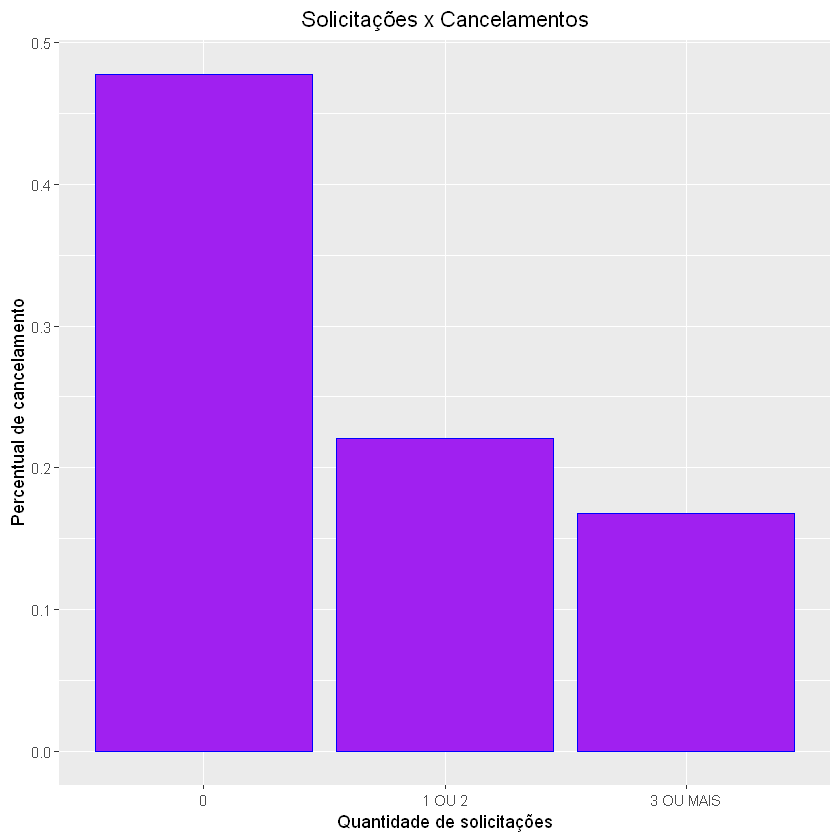

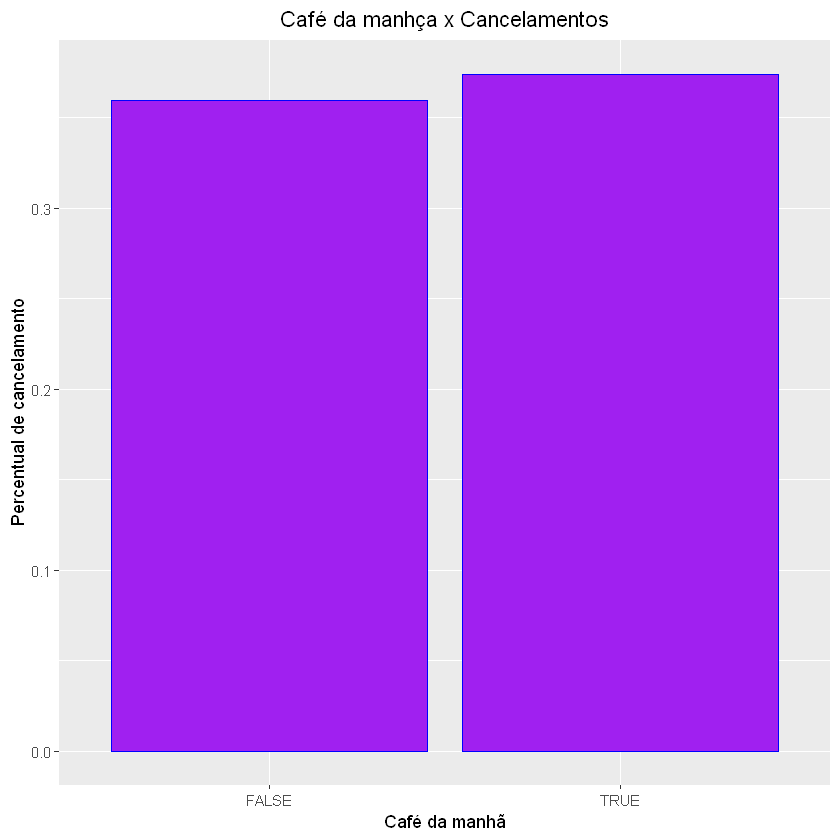

In [146]:
g1 <- ggplot(base, aes(x = solicitacoes, y = cancellation)) +
        geom_bar(stat = "summary",
                fun = mean,
                position = "dodge",color='blue',fill='purple')+
        labs(title="Solicitações x Cancelamentos",
             x = "Quantidade de solicitações",
             y = "Percentual de cancelamento",
                )+
                theme(plot.title = element_text(hjust = 0.5))
g1

g2 <- ggplot(base, aes(x = breakfast, y = cancellation)) +
        geom_bar(stat = "summary",
                fun = mean,
                position = "dodge",color='blue',fill='purple')+
        labs(title="Café da manhça x Cancelamentos",
             x = "Café da manhã",
             y = "Percentual de cancelamento",
                )+
                theme(plot.title = element_text(hjust = 0.5))
g2

__Utilizando a métrica de InformationValue (IV). Objetivos:__

- Definir as principais variáveis para desenvolvimento do modelo;

- Verificar se o resultado apresentado bate com o esperado das análises bivariadas.

In [90]:
IV <- create_infotables(data = base, y = 'cancellation')
IV$Summary

,Variable,IV
,<chr>,<dbl>
3,pais,0.5321907972
13,antecendencia,0.4867053450
15,cancelamento_previo,0.3901534997
4,segmento,0.3255657872
8,solicitacoes,0.3232654928
17,alteracoes,0.1804156293
5,canal,0.1550866591
16,estadia_previa,0.0962813230
1,type,0.0840021764


__Resultados - Information Value__
   - O IV indica que se faça uma melhor verificação na variável País. Como não há um padrão bem definido e problemas com a volumetria SEM INFO, deixarei a variável fora do modelo;
   - As variáveis com IV menor que 0,02 também deixei de fora visto que não devem exercer uma influência considerável no cancelamento, como já era esperado a partir das análises bivariadas.

In [99]:
print('Verificando a média de cancelamento da base de dados. Esse valor será utilizado como sugestão inicial de ponto de corte para classificação no modelo final.')
table(base$cancellation) %>% prop.table() %>% round(3)

[1] "Verificando a média de cancelamento da base de dados. Esse valor será utilizado como sugestão inicial de ponto de corte para classificação no modelo final."



    0     1 
0.629 0.371 

__Separação da Base para criação do modelo__
 - A base será dividida aleatoriamente para treino e teste nas proporções de 70% e 30% respectivamente.

In [91]:
#Semente de aleatoriedade definida
set.seed(220313)
amostra <- sample(1:nrow(base),nrow(base)*0.7) 
base$id <- row.names(base)
base_treino <- base[base$id %in% amostra,] 
base_teste <- base[!base$id %in% amostra,]

  __Treinamento do modelo de classificação: Regressão Logística__
  
   - O primeiro modelo testado incluia todas as variáveis com IV > 0,2 e, após testes, foram retiradas algumas variáveis com as seguintes justificativas:
       - A variável que indica a quantidade de noites da reserva foi retirada por não apresentar resultado significativo para o modelo (p-valor = 0,2543);
       - A variável segmento também foi retirada do modelo por apresentar um segmento não significativo a 95% de confiança (p-valor = 0,0514) e possivelmente ter uma relação com o canal que prejudica a interpretação do modelo;
       - A variável estadia prévia foi retirada por apresentar relação com cancelamento prévio e já trazer uma carga de incerteza pela baixa volumetria verificada na análise bivariada;
       - A variável canal foi retirada por apresentar um resultado não significativo para o modelo, com p-valor = 0,987. 
   - Deixarei o código para criação do modelo final após os testes.

In [96]:
modelo <- glm(cancellation ~ antecendencia+
                              cancelamento_previo+
                              #segmento+
                              solicitacoes+
                              alteracoes+
                              #dias+
                              #canal+
                              #estadia_previa+
                              type+
                              hospedes,
                base_treino[,-c('pais','breakfast','flag_fds','flag_semana','estacionamento','semana','quarto')],
               family = binomial(link = logit))
summary(modelo)


Call:
glm(formula = cancellation ~ antecendencia + cancelamento_previo + 
    solicitacoes + alteracoes + type + hospedes, family = binomial(link = logit), 
    data = base_treino[, -c("pais", "breakfast", "flag_fds", 
        "flag_semana", "estacionamento", "semana", "quarto")])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5688  -0.8228  -0.4503   0.9497   3.1858  

Coefficients:
                             Estimate Std. Error z value            Pr(>|z|)
(Intercept)                  -2.61218    0.05183  -50.40 <0.0000000000000002
antecendenciaDE 02 A 08 DIAS  0.61661    0.06076   10.15 <0.0000000000000002
antecendenciaDE 09 A 30 DIAS  1.77957    0.05297   33.59 <0.0000000000000002
antecendenciaDE 31 A 60 DIAS  2.13421    0.05279   40.43 <0.0000000000000002
antecendenciaMAIS DE 60 DIAS  2.49689    0.04981   50.13 <0.0000000000000002
cancelamento_previo1          2.99202    0.06284   47.61 <0.0000000000000002
solicitacoes1 OU 2           -1.17912    0.01776 

__Resumo de resultados do modelo:__

   - __Antecedência:__ quanto maior a antecedência que a reserva foi realizada, maior a chance de cancelamento;
   - __Cancelamento prévio:__ reservas de clientes que já cancelaram reservas têm chances bem maiores de serem canceladas;
   - __Segmentos:__ variável retirada do modelo;
   - __Solicitações:__ reservas que possuem solicitações a mais têm menos chance de cancelamento, sendo que 3 ou mais solicitações diminuem ainda mais essa probabilidade;
   - __Alterações:__ reservas com alterações também têm menos chance de cancelamento;
   - __Dias da reserva:__ variável retirada do modelo;
   - __Canal de distribuição:__ variável retirada do modelo;
   - __Tipo de hotel:__ reservas de hotéis "comuns" têm mais chance de ser canceladas.
   - __Estadia prévia:__ variável retirada do modelo;
   - __Quantidade de hóspedes:__ reservas com mais de 1 hóspede são mais propensas ao cancelamento.

__Avaliação dos resultados do modelo__

   - __VIF (Fator de Inflação da Variância):__ essa métrica será utilizada para avaliar a existência de multicolinearidade no modelo. Bons resultados nessa avaliação afastam o risco de estarmos trabalhando com variáveis de alta correlação entre si.
       - Em geral, os valores do VIF não devem ultrapassar 5. Chegando perto, é necessária uma melhor averiguação.

In [98]:
vif(modelo)
print('Os resultados próximos a 1 para todas as variáveis afastam o risco de multicolinearidade')

,GVIF,Df,GVIF^(1/(2*Df))
antecendencia,1.067102,4,1.008151
cancelamento_previo,1.021196,1,1.010542
solicitacoes,1.035019,2,1.008642
alteracoes,1.026735,1,1.013279
type,1.012351,1,1.006157
hospedes,1.098875,1,1.048272


[1] "Os resultados próximos a 1 para todas as variáveis afastam o risco de multicolinearidade"


__Ponto de corte e Classificação__

   - O ponto de corte inicial para classificação foi a média de cancelamentos da base (0,371);
   - Após avaliações, buscando um melhor ajuste de resultados, foi definido como ponto de corte final o valor de 0,368.

In [101]:
base_treino$prob = predict(modelo,base_treino, type = "response")
base_teste$prob = predict(modelo,base_teste, type = "response")
base_treino$predito <- ifelse(base_treino$prob > 0.368,1,0)
base_teste$predito <- ifelse(base_teste$prob > 0.368,1,0)

__Métricas de Avaliação do Modelo__

   - Base de Treino:
       
       - __Acurácia:__ 73% (Acerto geral)
       - __Sensibilidade:__ 74% (Acerto de cancelamentos)
       - __Especificidade:__ 71% (Acertos de não-cancelamentos)
       - __KS:__ 46%
       - __AUC(ROC):__ 78%
    
   - Base de Teste:
       
       - __Acurácia:__ 72%
       - __Sensibilidade:__ 74%
       - __Especificidade:__ 70%
       - __KS:__ 45%
       - __AUC(ROC):__ 78%
       
       
   - Além disso, podemos destacar o __Índice de Estabilidade da População (PSI) = 0,0003678624__ que nos indica um bom ajuste das variáveis explicativas do modelo, não havendo alterações entre as bases de treino e teste.     
       
Deixo os resultados 'ilustrados' abaixo para visualização

[1] "KS da base de treino:"


[1] 0.4571

[1] "KS da base de teste:"


[1] 0.4516

[1] "Curva ROC da base de treino"
[1] "Curva ROC da base de teste"


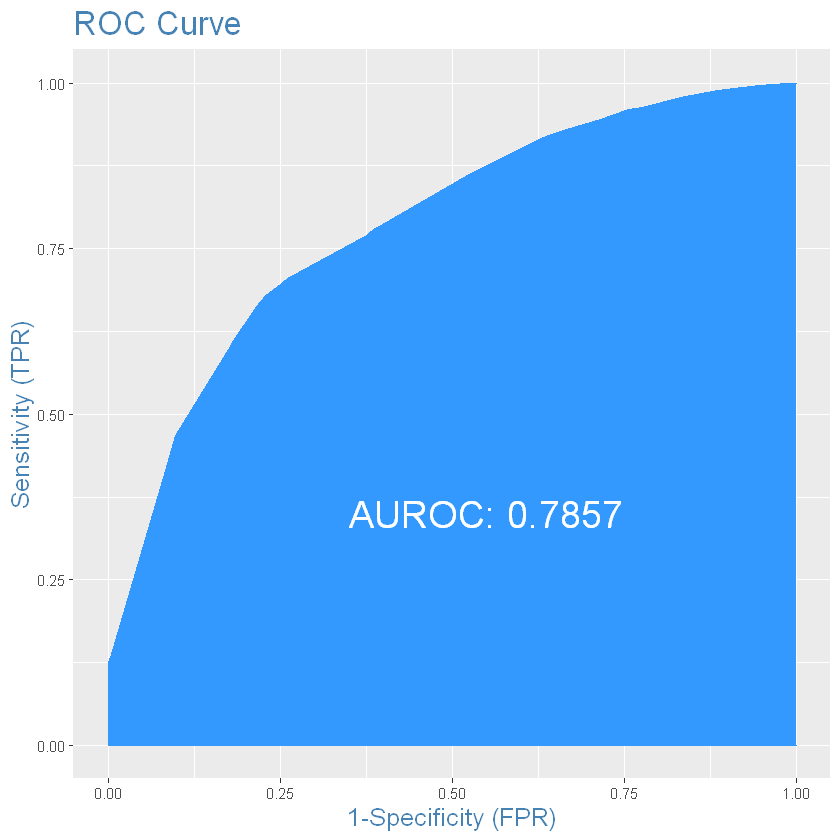

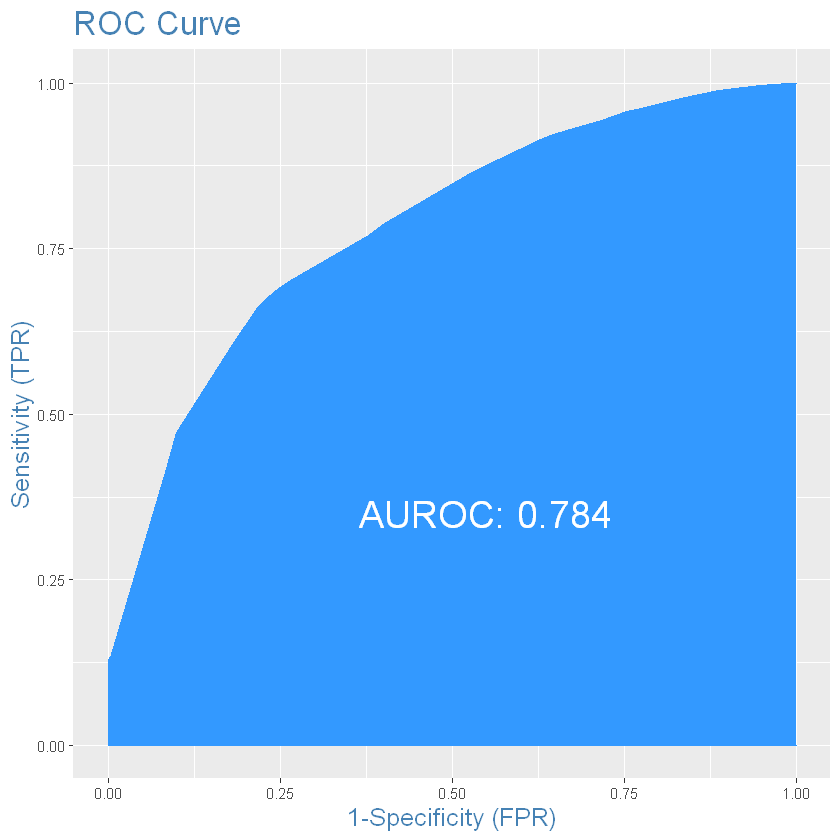

In [105]:
print('KS da base de treino:')
ks_stat(actuals=base_treino$cancellation, predictedScores=base_treino$prob)
print('KS da base de teste:')
ks_stat(actuals=base_teste$cancellation, predictedScores=base_teste$prob)
print('Curva ROC da base de treino')
plotROC(actuals=base_treino$cancellation, predictedScores=base_treino$prob)
print('Curva ROC da base de teste')
plotROC(actuals=base_teste$cancellation, predictedScores=base_teste$prob)


In [107]:
print('Métricas de avaliação da base de treino:')
confusionMatrix(as.factor(base_treino$predito),as.factor(base_treino$cancellation),positive='1')
print('Métricas de avaliação da base de teste:')
confusionMatrix(as.factor(base_teste$predito),as.factor(base_teste$cancellation),positive='1')

[1] "Métricas de avaliação da base de treino:"


Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 38832  9124
         1 13650 21827
                                               
               Accuracy : 0.727                
                 95% CI : (0.724, 0.7301)      
    No Information Rate : 0.629                
    P-Value [Acc > NIR] : < 0.00000000000000022
                                               
                  Kappa : 0.4322               
                                               
 Mcnemar's Test P-Value : < 0.00000000000000022
                                               
            Sensitivity : 0.7052               
            Specificity : 0.7399               
         Pos Pred Value : 0.6152               
         Neg Pred Value : 0.8097               
             Prevalence : 0.3710               
         Detection Rate : 0.2616               
   Detection Prevalence : 0.4252               
      Balanced Accuracy : 0.7226               
              

[1] "Métricas de avaliação da base de teste:"


Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 16571  3939
         1  5958  9292
                                               
               Accuracy : 0.7232               
                 95% CI : (0.7186, 0.7279)     
    No Information Rate : 0.63                 
    P-Value [Acc > NIR] : < 0.00000000000000022
                                               
                  Kappa : 0.4245               
                                               
 Mcnemar's Test P-Value : < 0.00000000000000022
                                               
            Sensitivity : 0.7023               
            Specificity : 0.7355               
         Pos Pred Value : 0.6093               
         Neg Pred Value : 0.8079               
             Prevalence : 0.3700               
         Detection Rate : 0.2598               
   Detection Prevalence : 0.4265               
      Balanced Accuracy : 0.7189               
              

$pic
$pic$pred


$psi
   variable      dataset          psi
1:     pred treino_teste 0.0003678624


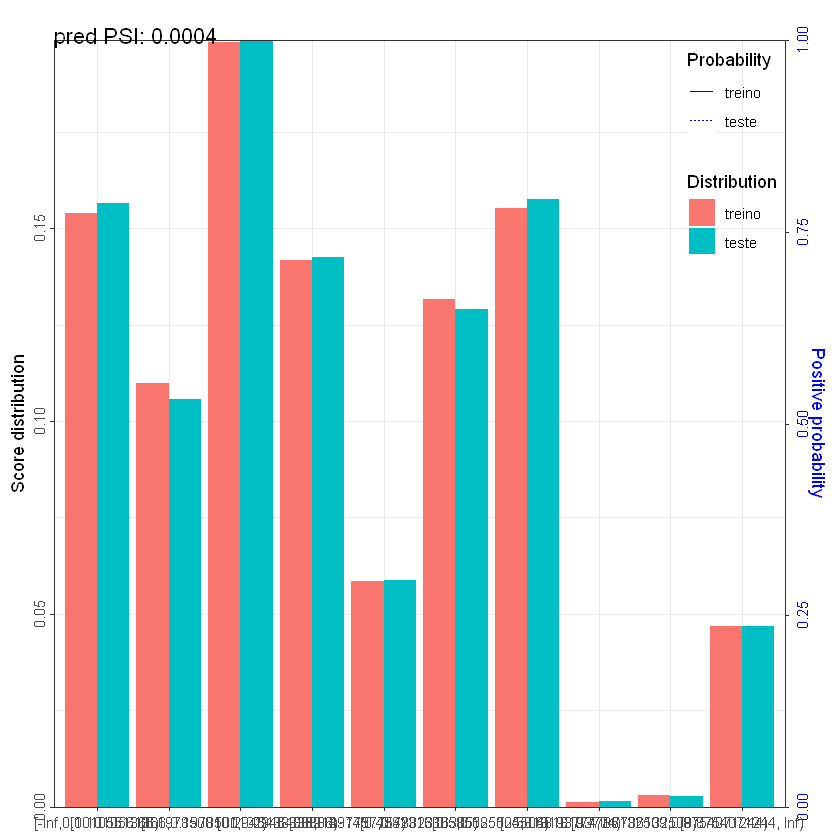

In [109]:
perf_psi(score = list(treino = base_treino$prob, teste = base_teste$prob))

__Cross Validation x Validação Out-of-time__

   - Nesta base específicamente, a validação out-of-time utilizando 2015 e 2016 para prever 2017 não deve apresentar um bom resultado. Explico:
       - Apesar de termos dados temporais, que nos permitem trabalhar com essa validação, temos divergências entre as periodiciades dos anos;
       - Em 2016 temos dados completos, de janeiro a dezembro. Porém, enquanto em 2015 não temos dados do início do ano (os dados disponíveis trazem reservas realizadas a partir de Julho), o ano de 2017 não apresenta os dados de reservas do final do ano (os dados disponíveis acabam no mês de Agosto).
       - A divergência de períodos pode trazer problemas causados por características de sazonalidade nos padrões de cancelamento, fazendo com que os resultados acabem não refletindo bem a realidade, diminuindo a acurácia do modelo.
    
   - O cross validation, que consiste em um conjunto de hold out validantion, não traz esse problema das questões temporais, dado que todas as observações passarão pelo menos uma vez pela parte de validação aleatoriamente. Com isso, esse método é mais eficiente em eliminar possíveis problemas de overfitting enquanto o out-of-time é mais eficiente em identificar mudanças de comportamento ao longo do tempo.

__Resultados - Cross Validation__

  - Realizando um Cross-validation pelo método k-fold temos os seguintes resultados:

       - __K=5 com 5 repetições__
       - Acurácia: 74%
       
       - __K=10 com 3 repetições__
       - Acurácia: 74%
       
       
   - Os resultados ratificam a precisão encontrada na validação treino/teste simples, eliminando hipóteses de overfitting e nos dando ainda mais garantia para a qualidade do modelo.
       
  Deixo os resultados 'ilustrados' abaixo para visualização:

In [112]:
print('Cross validation, K-fold com K=5 e 5 repetições')
fitControl <- trainControl(## 5-fold CV
  method = "repeatedcv",
  number = 5,
  ## 5 repetições
  repeats = 5)

set.seed(220313)
md1 <- train(as.factor(cancellation) ~ antecendencia+
                                       cancelamento_previo+
                                       alteracoes+
                                       solicitacoes+
                                       type+
                                       hospedes, data = base, 
                method = "glm",preProcess = c("scale"), family="binomial", 
                trControl = fitControl,
             na.action=na.exclude)
md1

print('Cross validation, K-fold com K=10 e 3 repetições')

fitControl <- trainControl(## 5-fold CV
  method = "repeatedcv",
  number = 10,
  ## 3 repetições
  repeats = 3)

set.seed(220313)
md2 <- train(as.factor(cancellation) ~ antecendencia+
                                       cancelamento_previo+
                                       alteracoes+
                                       solicitacoes+
                                       type+
                                       hospedes, data = base, 
                method = "glm",preProcess = c("scale"), family="binomial", 
                trControl = fitControl,
             na.action=na.exclude)
md2

[1] "Cross validation, K-fold com K=5 e 5 repetições"


Generalized Linear Model 

119197 samples
     6 predictor
     2 classes: '0', '1' 

Pre-processing: scaled (10) 
Resampling: Cross-Validated (5 fold, repeated 5 times) 
Summary of sample sizes: 95353, 95355, 95354, 95355, 95355, 95354, ... 
Resampling results:

  Accuracy   Kappa    
  0.7409697  0.4344176


[1] "Cross validation, K-fold com K=10 e 3 repetições"


Generalized Linear Model 

119197 samples
     6 predictor
     2 classes: '0', '1' 

Pre-processing: scaled (10) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 107273, 107274, 107273, 107274, 107274, 107274, ... 
Resampling results:

  Accuracy   Kappa    
  0.7409887  0.4344706


__OBRIGADO!__